# SARIMAX and ARIMA forecasters

SARIMAX (Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors) is a generalization of the ARIMA model that considers both seasonality and exogenous variables. SARIMAX models are among the most widely used statistical models for forecasting and their performance can be very high.

A SARIMAX model is usually denoted $SARIMA(p,d,q)(P,D,Q)m$, where 

+ $p$ is the order (number of time lags) of the autoregressive part of the model.

+ $d$ is the degree of differencing (the number of times the data have had past values subtracted).

+ $q$ is the order of the moving-average part of the model.

+ $P$ is the order (number of time lags) of the seasonal part of the model

+ $D$ is the degree of differencing (the number of times the data have had past values subtracted) of the seasonal part of the model.

+ $Q$ is the order of the moving-average of the seasonal part of the model.

+ $m$ refers to the number of periods in each season.

When two out of the three terms are zeros, the model may be referred to based on the non-zero parameter, dropping "AR", "I" or "MA" from the acronym describing the model. For example, $ARIMA(1,0,0)$ is $AR(1)$, $ARIMA(0,1,0)$ is $I(1)$, and $ARIMA(0,0,1)$ is $MA(1)$.

The class `ForecasterSarimax` allows to train and validate SARIMAX models from [pmdarima](http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA) (internally wraps the [statsmodels SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)) using the skforecast API. This facilitates the comparison of their performance with other machine learning models.


## Libraries

In [1]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from pmdarima import ARIMA
from sklearn.metrics import mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data

Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


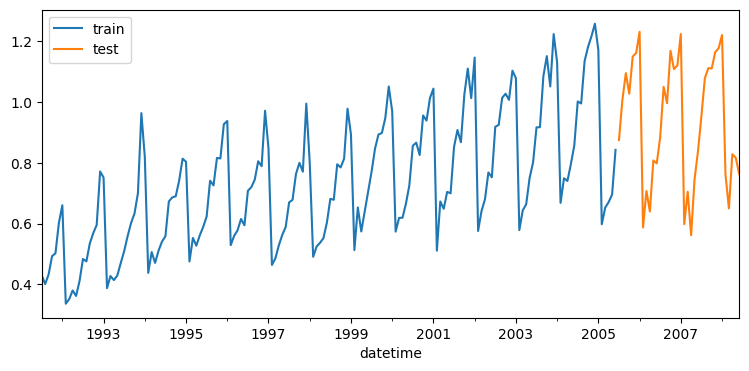

In [3]:
# Download data
# ======================================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ======================================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Train-test dates
# ======================================================================================
end_train = '2005-06-01 23:59:00'
print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  (n={len(data.loc[end_train:])})")
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Train ForecasterSarimax

In [4]:
# Create and fit forecaster
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor = ARIMA(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(y=data_train)
forecaster

ForecasterSarimax 
Regressor:  ARIMA(12,1,1)(0,0,0)[0] intercept 
Regressor parameters: {'maxiter': 200, 'method': 'lbfgs', 'order': (12, 1, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': False, 'trend': None, 'with_intercept': True} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Creation date: 2023-03-08 14:47:18 
Last fit date: 2023-03-08 14:47:22 
Index seen by the forecaster: DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2004-09-01', '2004-10-01', '200

## Prediction

In [5]:
# Predict
# ======================================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    0.972575
2005-08-01    0.980463
2005-09-01    1.135129
Freq: MS, Name: pred, dtype: float64

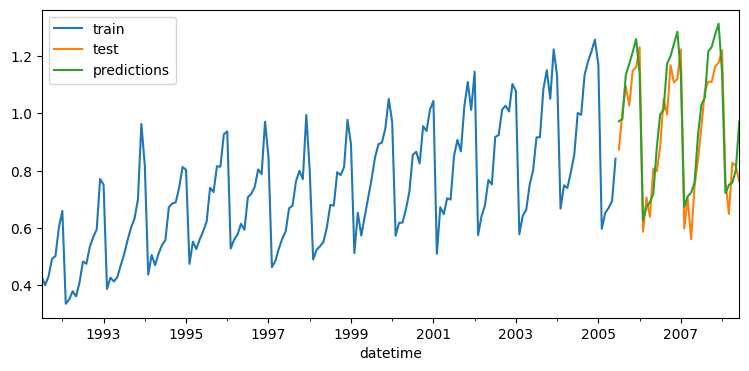

In [6]:
# Plot predictions
# ======================================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [7]:
# Prediction error
# ======================================================================================
error_mse = mean_absolute_error(
                y_true = data_test,
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.08398095770987783


## Prediction intervals

In [8]:
# Predict intervals
# ======================================================================================
predictions = forecaster.predict_interval(steps=36, interval=[5, 95])
predictions.head(3)

,pred,lower_bound,upper_bound
2005-07-01,0.972575,0.875051,1.070099
2005-08-01,0.980463,0.877568,1.083358
2005-09-01,1.135129,1.028896,1.241363


## Feature importance

In [9]:
forecaster.get_feature_importance()

,feature,importance
0,intercept,0.004831
1,ar.L1,-0.109302
2,ar.L2,-0.138044
3,ar.L3,-0.109821
4,ar.L4,-0.157437
5,ar.L5,-0.127060
6,ar.L6,-0.115060
7,ar.L7,-0.160059
8,ar.L8,-0.108337
9,ar.L9,-0.134818


## Backtesting ForecasterSarimax

SARIMAX models can be evaluated using any of the [backtesting strategies](https://joaquinamatrodrigo.github.io/skforecast/latest/introduction-forecasting/introduction-forecasting.html#backtesting-forecasting-models) implemented in skforecast.

In [10]:
# Backtest forecaster
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor = ARIMA(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

metric, predictions = backtesting_sarimax(
                          forecaster         = forecaster,
                          y                  = data,
                          initial_train_size = len(data_train),
                          fixed_train_size   = False,
                          steps              = 12,
                          metric             = 'mean_absolute_error',
                          refit              = True,
                          verbose            = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 168
Number of observations used for backtesting: 36
    Number of folds: 3
    Number of steps per fold: 12

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=168)
    Validation: 2005-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=12)
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=180)
    Validation: 2006-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=12)
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=192)
    Validation: 2007-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=12)



In [11]:
print(f"Error backtest: {metric}")

Error backtest: 0.06973314211549979


In [12]:
predictions.head(4)

,pred
2005-07-01,0.972575
2005-08-01,0.980463
2005-09-01,1.135129
2005-10-01,1.173011


## Model tunning

The best SARIMAX model hyperparameters can be found using any of the [hyperparameters optimization strategies](https://joaquinamatrodrigo.github.io/skforecast/master/user_guides/hyperparameter-tuning-and-lags-selection.html#hyperparameter-tuning-and-lags-selection) implemented in skforecast.

Train dates      : 1991-07-01 00:00:00 --- 2001-01-01 00:00:00  (n=115)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=29)


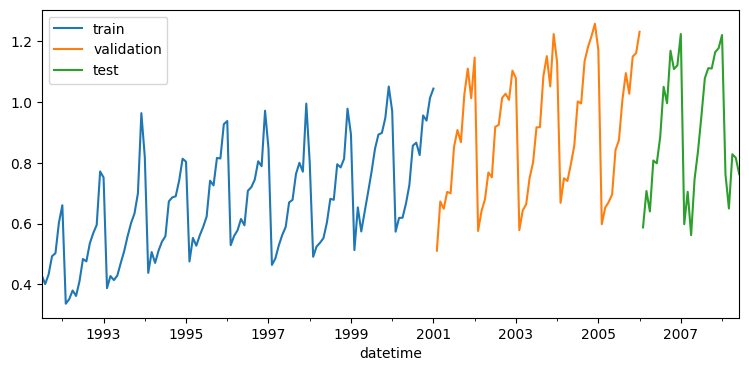

In [13]:
# Train-validation-test dates
# ======================================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  (n={len(data.loc[end_train:end_val])})")
print(f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_val:])})")

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.legend();

In [14]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor = ARIMA(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

param_grid = {'order': [(12, 0, 0), (12, 1, 0), (12, 1, 1), (14, 1, 4)],
              'seasonal_order': [(0, 0, 0, 0)],
              'trend': [None, 'n', 'c']}

results_grid = grid_search_sarimax(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val],
                   param_grid         = param_grid,
                   steps              = 12,
                   refit              = True,
                   metric             = 'mean_absolute_error',
                   initial_train_size = len(data_train),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 12.


loop param_grid: 100%|████████████████████████████████████| 12/12 [00:30<00:00,  2.56s/it]


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}
  Backtesting metric: 0.06805053775564675



In [15]:
results_grid

,params,mean_absolute_error,order,seasonal_order,trend
7,"{'order': (12, 1, 1), 'seasonal_order': (0, 0,...",0.068051,"(12, 1, 1)","(0, 0, 0, 0)",n
10,"{'order': (14, 1, 4), 'seasonal_order': (0, 0,...",0.072275,"(14, 1, 4)","(0, 0, 0, 0)",n
0,"{'order': (12, 0, 0), 'seasonal_order': (0, 0,...",0.076132,"(12, 0, 0)","(0, 0, 0, 0)",None
2,"{'order': (12, 0, 0), 'seasonal_order': (0, 0,...",0.076132,"(12, 0, 0)","(0, 0, 0, 0)",c
1,"{'order': (12, 0, 0), 'seasonal_order': (0, 0,...",0.076644,"(12, 0, 0)","(0, 0, 0, 0)",n
4,"{'order': (12, 1, 0), 'seasonal_order': (0, 0,...",0.079491,"(12, 1, 0)","(0, 0, 0, 0)",n
6,"{'order': (12, 1, 1), 'seasonal_order': (0, 0,...",0.080460,"(12, 1, 1)","(0, 0, 0, 0)",None
8,"{'order': (12, 1, 1), 'seasonal_order': (0, 0,...",0.080460,"(12, 1, 1)","(0, 0, 0, 0)",c
3,"{'order': (12, 1, 0), 'seasonal_order': (0, 0,...",0.100697,"(12, 1, 0)","(0, 0, 0, 0)",None
5,"{'order': (12, 1, 0), 'seasonal_order': (0, 0,...",0.100697,"(12, 1, 0)","(0, 0, 0, 0)",c


In [16]:
forecaster

ForecasterSarimax 
Regressor:  ARIMA(12,1,1)(0,0,0)[0] intercept 
Regressor parameters: {'maxiter': 200, 'method': 'lbfgs', 'order': (12, 1, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': False, 'trend': 'n', 'with_intercept': True} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2006-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Creation date: 2023-03-08 14:47:33 
Last fit date: 2023-03-08 14:48:05 
Index seen by the forecaster: DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2005-04-01', '2005-05-01', '2005

In [17]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>